## MNIST Classification / Generation using AUNN

## Setup & Definition

In [1]:
import torch
import random
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [2]:
class AUNNModel(nn.Module):
    def __init__(self, embedding_dim:int, output_dim:int, num_layers:int, hidden_dim:int):

        assert num_layers >= 2, "Number of layers must be at least 2"

        super(AUNNModel, self).__init__()
    
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer =  nn.Linear(self.embedding_dim, self.hidden_dim)

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU()
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    # def encode(self, x, dim):

    #     position = x.unsqueeze(1)
    #     device = x.device  # Get the device of x

    #     # Create div_term on the same device as x
    #     div_term = torch.exp(
    #         torch.arange(0, dim, 2, dtype=torch.float32, device=device) *\
    #             (-np.log(10_000.0) / dim)
    #     )

    #     # Create pe on the same device as x
    #     pe = torch.zeros(x.size(0), dim, device=device)

    #     # Perform computations
    #     pe[:, 0::2] = torch.sin(position * div_term)
    #     pe[:, 1::2] = torch.cos(position * div_term)
    #     return pe

    def encode(self, x: torch.Tensor, dim: int = 128):

        assert dim % 2 == 0, "Encoding dimension (dim) must be even."

        # Determine the number of frequencies
        num_frequencies = dim // 2

        # Frequencies corresponding to powers of two, starting from 2^2
        frequency_powers = torch.arange(2, 2 + num_frequencies, dtype=torch.float32, device=x.device)
        frequencies = 2 ** frequency_powers  # Shape: [num_frequencies]

        # Compute the angles: [N, num_frequencies]
        x = x.unsqueeze(1)  # Shape: [N, 1]
        angles = (2 * torch.pi * x) / frequencies  # Broadcasting over x and frequencies

        # Compute the positional encodings
        encoding = torch.zeros(x.size(0), dim, device=x.device)
        encoding[:, 0::2] = torch.sin(angles)  # Even indices: sin
        encoding[:, 1::2] = torch.cos(angles)  # Odd indices: cos

        return encoding


    def forward(self, indices):
        
        x = self.encode(indices, self.embedding_dim)
        x = self.input_layer(x)
        x = x + nn.SiLU()(x)

        for layer in self.layers:
            x = x + layer(x)  # MLP output with skip connection

        x = self.output_layer(x)

        return x

In [3]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint[k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [4]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    params = {k: checkpoint[k] for k in keys}
    
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

## Prepare MNIST

In [5]:
import struct
from array import array

def load_mnist(images_path, labels_path, shuffle=False, seed=42):

    labels = []
    with open(labels_path, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8)) 
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    images = []
    rows, cols = None, None
    with open(images_path, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        data = array("B", file.read())
        for i in range(size):
            img = np.array(data[i * rows * cols:(i + 1) * rows * cols], dtype=np.uint8)
            img = np.where(img > 0, 1, 0) #binarize
            img.resize((rows, cols))
            images.append(img)

    assert len(images) == len(labels)

    if shuffle:
        random.seed(seed)
        indices = list(range(len(images)))
        random.shuffle(indices)
        images = [images[i] for i in indices]
        labels = [labels[i] for i in indices]

    return images, labels

def make_bitstring(images, labels, bos_len = 10):
    
    targets = []
    for img, label in zip(images, labels):

        #add a begin-sequence indicators
        begin_sequence = np.ones(bos_len, dtype=np.uint8)
        targets.append(begin_sequence)

        #one hot encode the label
        label_date = np.zeros(10, dtype=np.uint8)
        label_date[label] = 1
        targets.append(label_date)

        #add image to inputs
        img_data = img.flatten()
        targets.append(img_data)

        #add the label again
        label_data = np.zeros(10, dtype=np.uint8)
        label_data[label] = 1
        targets.append(label_data)

    targets = np.concatenate(targets, axis=0)
    return targets

In [6]:
from pathlib import Path

cur_dir = Path().resolve()
input_path = cur_dir / 'mnist'
training_images_filepath = input_path / 'train-images.idx3-ubyte'
training_labels_filepath = input_path /'train-labels.idx1-ubyte'
test_images_filepath = input_path / 't10k-images.idx3-ubyte'
test_labels_filepath = input_path / 't10k-labels.idx1-ubyte'

train_images, train_labels = load_mnist(training_images_filepath, training_labels_filepath)
train_bitstring = make_bitstring(train_images, train_labels)
print(len(train_bitstring))

48840000


In [7]:
#shuffle train_bitstring
selectors = np.arange(len(train_bitstring))
np.random.seed(42)
np.random.shuffle(selectors)
indices = np.arange(len(train_bitstring))
train_bitstring = train_bitstring[selectors]
indices = indices[selectors]

## Train

In [8]:
# Hyperparameters

embedd_dim = 128
num_layers = 8    # Must be even and at least 2 (bc of skip connections)
hidden_dim = 1024  # Size of hidden layers
output_dim = 2
batch_size = 4096
num_epochs = 500

In [9]:
# Initialize the model, loss function, and optimizer
model = AUNNModel(embedd_dim, output_dim, num_layers, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
print(f"Model has {model.count_params():,} parameters")

Model has 6,431,746 parameters


In [10]:
train_bitstring = torch.tensor(train_bitstring, dtype=torch.uint8).to(device)
indices = torch.tensor(indices, dtype=torch.uint8).to(device)

#training loop
num_batches = len(train_bitstring) // batch_size
if len(train_bitstring) % batch_size != 0:
    num_batches += 1
losses = []
for epoch in range(num_epochs):
    for batch_num in tqdm(list(range(num_batches))):

        start = batch_num * batch_size
        end = start + batch_size
        targets = train_bitstring[start:end]
        inputs = indices[start:end]
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #clip gradients
        optimizer.step()
        optimizer.zero_grad(set_to_none=True) #flush gradients

        if loss != loss:
            print("ERR loss is NaN")

        cur_loss = loss.item()
        losses.append(cur_loss)

        if batch_num % 1000 == 0: # batch logging
            avg_loss = np.mean(losses[-1000:])
            print(f"Batch [{batch_num}/{num_batches}], Loss: {avg_loss:.8f}")

  0%|          | 0/11924 [00:00<?, ?it/s]

Batch [0/11924], Loss: 16.03270149
Batch [1000/11924], Loss: 1.07178103
Batch [2000/11924], Loss: 0.49962048
Batch [3000/11924], Loss: 0.49981332
Batch [4000/11924], Loss: 0.49923741
Batch [5000/11924], Loss: 0.49939789
Batch [6000/11924], Loss: 0.49941404
Batch [7000/11924], Loss: 0.49977783
Batch [8000/11924], Loss: 0.49940118
Batch [9000/11924], Loss: 0.49903649
Batch [10000/11924], Loss: 0.49911233


KeyboardInterrupt: 

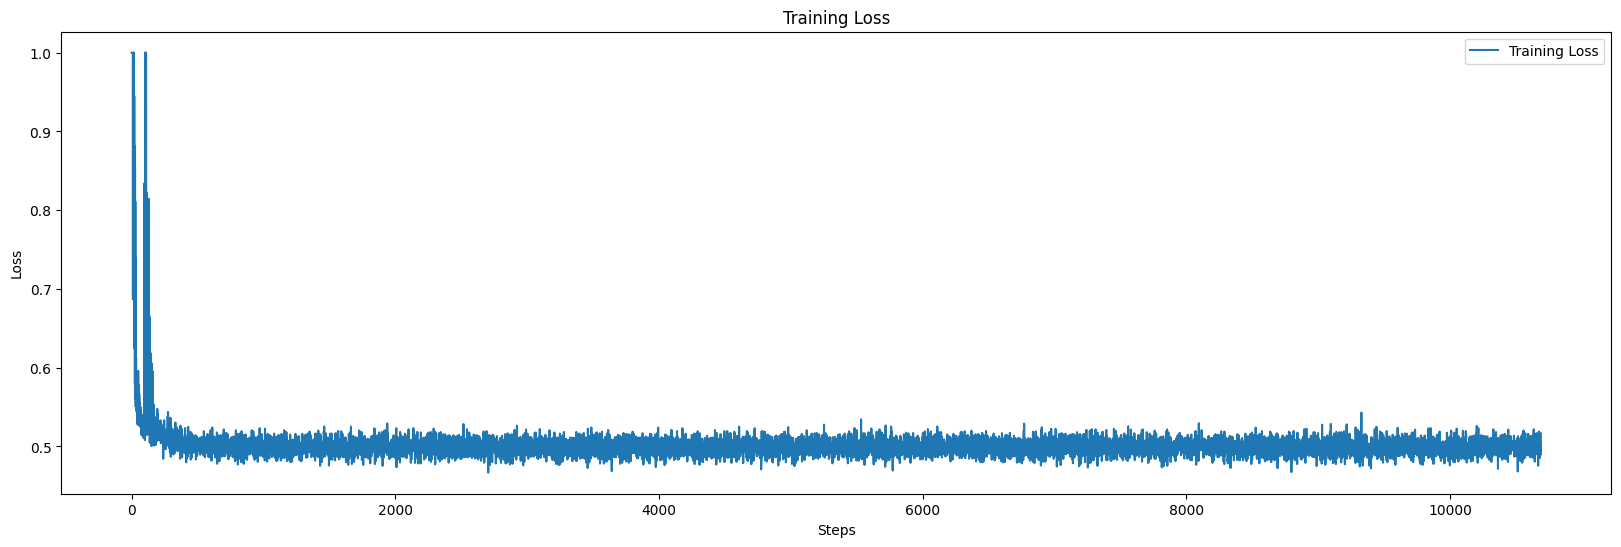

In [12]:
# Plot the loss curves
temp = [x if x < 1 else 1 for x in losses] #clip losses to 1
plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

In [ ]:
save_checkpoint(model, {
    'embedding_dim': embedd_dim,
    'output_dim': output_dim,
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}, optimizer, losses, filename="aunn_mnist.pth")

In [13]:
bitstring = make_bitstring(train_images[:1], train_labels[:1])
print(len(bitstring))

bos = bitstring[:10]
lbl = bitstring[10:20]
img = bitstring[20:20+784]
lbl2 = bitstring[20+784:20+784+10]

print(bos)
print(lbl)
print(img.reshape(28, 28))
print(lbl2)

start = 0
indices = torch.arange(start, start + len(bitstring), device=device)
with torch.no_grad():
    outputs = model(indices)
    outputs = torch.argmax(outputs, dim=1)

outputs = outputs.cpu().numpy()
bos = outputs[start:start+10]
lbl = outputs[start+10:start+20]
img = outputs[start+20:start+20+784]
lbl2 = outputs[start+20+784:start+20+784+10]

print('-'*20)
print(bos)
print(lbl)
print(img.reshape(28, 28))
print(lbl2)

814
[1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 1 0 0 0 0]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 

In [ ]:
bos = np.ones(10, dtype=np.uint8)
lbl = np.zeros(10, dtype=np.uint8)
lbl[5] = 1

target = np.concatenate([bos, lbl], axis=0)
target = torch.tensor(target, dtype=torch.uint8, device=device)
indices = torch.arange(100000000, 100000000+len(target), device=device)

#train the model
model.train()
num_steps = 10
for _ in range(num_steps):
    outputs = model(indices)
    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    print(loss.item())

#test the model
model.eval()
entry_len = 814
indices = torch.arange(100000000, 100000000+entry_len, device=device)
outputs = model(indices)
outputs = torch.argmax(outputs, dim=1)
outputs = outputs.cpu().numpy()

bos = outputs[:10]
lbl = outputs[10:20]
img = outputs[20:20+784]
lbl2 = outputs[20+784:20+784+10]

print('-'*20)
print(bos)
print(lbl)
print(img.reshape(28, 28))
print(lbl2)
